In [1]:
import warnings
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import KeyedVectors


import gensim
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string



warnings.filterwarnings("ignore")   

In [2]:
data = pd.read_csv("mix_data.csv")
data[ data["label"] == "job_applicant"].head()

,email_body,label
0,"Dear Hiring Manager,\n\nI wish to inquire abou...",job_applicant
1,"Dear [Company Name] Team,\n\nHaving followed G...",job_applicant
2,Please accept this email as my formal applicat...,job_applicant
3,"Dear Hiring Manager,\n\nI am excited to apply ...",job_applicant
4,"Hi there,\n\nHaving followed Synergy Systems's...",job_applicant


In [3]:
class_counts  = data["label"].value_counts()

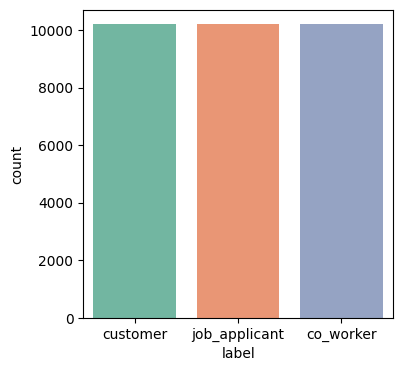

In [4]:
plt.figure(figsize = (4, 4 ) )
sns.countplot( data = data ,  x = "label" , order = class_counts.index , palette = "Set2")
plt.show()

In [3]:
data = pd.read_pickle("large_data.pkl") 
data.head()

,email_body,label,tokens,average_vector
0,"Dear Hiring Manager,\n\nI wish to inquire abou...",job_applicant,"[dear, hiring, manager, wish, inquire, possibi...","[-0.02783203125, 0.06353494395380435, 0.024629..."
1,"Dear [Company Name] Team,\n\nHaving followed G...",job_applicant,"[dear, company, team, having, follow, global, ...","[-0.06311394186580882, 0.02129049862132353, -0..."
2,Please accept this email as my formal applicat...,job_applicant,"[accept, email, formal, application, graphic, ...","[-0.037270210884712836, 0.0074240194784628375,..."
3,"Dear Hiring Manager,\n\nI am excited to apply ...",job_applicant,"[dear, hiring, manager, excited, apply, graphi...","[-0.0521661376953125, 0.014130859375, -0.00042..."
4,"Hi there,\n\nHaving followed Synergy Systems's...",job_applicant,"[hi, having, follow, synergy, systems, work, t...","[-0.02624359130859375, 0.010528782435825893, -..."


In [153]:
data = pd.read_pickle("small_data.pkl")

In [154]:
import numpy as np
import pandas as pd

def add_label_noise_by_class(data, label_col='label', random_state=42):
    """
    Injecte du bruit dans la colonne des labels selon un pourcentage par classe.
    """
    np.random.seed(random_state)
    noisy_data = data.copy()
    labels = noisy_data[label_col].unique()
    noise_dict = {'job_applicant': 0.1, 'customer': 0.1, 'co_worker': 0.05}

    for label, prop in noise_dict.items():
        # Indices de la classe courante
        label_indices = noisy_data[noisy_data[label_col] == label].index
        n_to_flip = int(prop * len(label_indices))
        if n_to_flip == 0:
            continue
        # Choisir les indices à flipper
        flip_indices = np.random.choice(label_indices, size=n_to_flip, replace=False)
        # Assigner un label différent
        for idx in flip_indices:
            possible_labels = [lbl for lbl in labels if lbl != label]
            new_label = np.random.choice(possible_labels)
            noisy_data.at[idx, label_col] = new_label

    return noisy_data

noisy_data = add_label_noise_by_class(data, label_col='label', random_state=42)

In [155]:
noisy_data["label"].value_counts()

label
co_worker        10670
job_applicant     9970
customer          9961
Name: count, dtype: int64

In [156]:
data = noisy_data
X = data["average_vector"].to_list()
y = data["label"].to_list()

In [157]:
X_train , X_test , y_train , y_test = train_test_split ( 
    X , 
    y , 
    test_size = 0.2 , 
    random_state = 42 ,
    shuffle = True
)

In [150]:
import numpy as np


# Train with shuffled labels
model = LogisticRegression()
model.fit(X_train, y_train)
logistic_score = model.score(X_test, y_test)

print(f"LogisticRegression Score is {logistic_score * 100: .2f} %")



LogisticRegression Score is  72.15 %


In [140]:
import spacy 
nlp_small = spacy.load("en_core_web_sm") # small file 
stop_words_small = nlp_small.Defaults.stop_words

def tokenizer(sentence):
    punctuations = string.punctuation
                   
    doc = nlp_small(sentence)  # -> tokenization

    mytokens = []
    for word in doc:
        lemma = word.lemma_.lower().strip() # removing the whitespace & lemmatization and lowercuase
        mytokens.append(lemma)

    filtered_tokens = []
    for word in mytokens:
        if word not in stop_words_small and word not in punctuations:
            filtered_tokens.append(word)

    return filtered_tokens
wv = KeyedVectors.load("word2vec-google-news-300.model")
import numpy as np
def avg_vector(sent):
    vector_size = wv.vector_size
    average_vector = np.zeros(vector_size)
    valid_word_count = 0

    for word in sent:
        if word in wv:
            average_vector += wv[word]
            valid_word_count += 1

    if valid_word_count > 0:
        average_vector /= valid_word_count
    return average_vector

In [141]:
def predict_(sentence):
    words = tokenizer(sentence)
    average_vector = avg_vector(words)
    return model.predict([average_vector])

In [142]:
y_pred = model.predict(X_test) 

<Figure size 300x300 with 0 Axes>

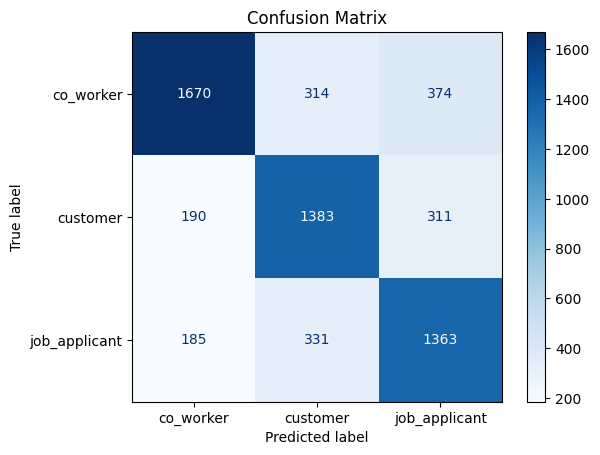

In [143]:
cm = confusion_matrix (y_test , y_pred , labels = model.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize = (3 , 3))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [144]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    co_worker       0.82      0.71      0.76      2358
     customer       0.68      0.73      0.71      1884
job_applicant       0.67      0.73      0.69      1879

     accuracy                           0.72      6121
    macro avg       0.72      0.72      0.72      6121
 weighted avg       0.73      0.72      0.72      6121



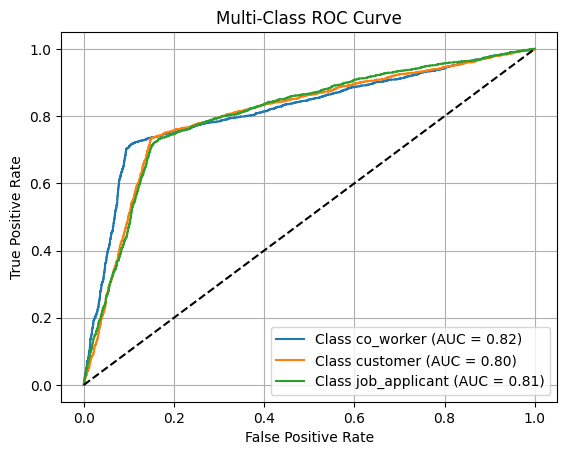

<Figure size 1000x800 with 0 Axes>

In [145]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

classes = model.classes_  
y_test_bin = label_binarize(y_test, classes=classes) #[customer] -> [0 , 1 , 0] ||| co_worker -> [1 , 0 , 0]
y_score = model.predict_proba(X_test)  

fpr = dict()
tpr = dict()
roc_auc = dict()
tresh_hold_counter = 0 
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i],drop_intermediate=False)
    tresh_hold_counter = len(_)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})" ,)

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.figure(figsize = (10 , 8 ) )

plt.show()
